In [1]:
!git clone https://github.com/pondelion/Algotham.git

Cloning into 'Algotham'...
remote: Enumerating objects: 251, done.
remote: Counting objects: 100% (251/251), done.
remote: Compressing objects: 100% (152/152), done.
remote: Total 251 (delta 100), reused 214 (delta 70), pack-reused 0
Receiving objects: 100% (251/251), 60.84 KiB | 6.76 MiB/s, done.
Resolving deltas: 100% (100/100), done.


In [1]:
%cd Algotham

/content/Algotham


In [3]:
ls

algotham/  examples/  Pipfile  Pipfile.lock  README.md  requirements.txt


In [4]:
!pip install -r requirements.txt

     |████████████████████████████████| 133kB 2.8MB/s 
     |████████████████████████████████| 6.5MB 27.6MB/s 
     |████████████████████████████████| 14.5MB 304kB/s 
     |████████████████████████████████| 10.5MB 189kB/s 
     |████████████████████████████████| 512kB 43.1MB/s 
     |████████████████████████████████| 276kB 46.8MB/s 
     |████████████████████████████████| 133kB 45.1MB/s 
  Created wheel for jpbizday: filename=jpbizday-0.0.3-cp36-none-any.whl size=4327 sha256=d9254e012d3a2cb62b848a0b612985e61028663f02ff5022b8020f2032886672
  Stored in directory: /root/.cache/pip/wheels/22/0b/ae/e12bc194a7a22998e2a13ea88526a6df0f5e9e394d7904b72b
  Created wheel for overrides: filename=overrides-3.1.0-cp36-none-any.whl size=10174 sha256=e6789c1b8b3ecd5372e94367f80787719fda3bdde49c3630761cd483b7623273
  Stored in directory: /root/.cache/pip/wheels/5c/24/13/6ef8600e6f147c95e595f1289a86a3cc82ed65df57582c65a9
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=4

In [2]:
!echo 'ACCESS_KEY_ID: *******' >> algotham/config/aws.yml
!echo 'SECRET_ACCESS_KEY: *******'' >> algotham/config/aws.yml
!echo 'REGION_NAME: ap-northeast-1' >> algotham/config/aws.yml
!echo 'S3_BUCKET_NAME: fin-app' >> algotham/config/aws.yml
!echo 'S3_BUCKET_NAME: fin-app' >> algotham/config/aws.yml

In [3]:
!echo 'STOCKLIST_FILE: s3://fin-app/stocklist/stocklist.csv' >> algotham/config/data_location.yml
!echo 'STOCKPRICE_BASEDIR: s3://fin-app/stockprice' >> algotham/config/data_location.yml
!echo 'STOCKPRICE_CONCAT_BASEDIR: s3://fin-app/stockprice_concat' >> algotham/config/data_location.yml
!echo 'STOCKPRICE_CANDLECHART_BASEDIR: s3://fin-app/stockprice_candlechart' >> algotham/config/data_location.yml
!echo 'ECONOMIC_INDICATOR_BASEDIR: s3://fin-app/economic_indicator' >> algotham/config/data_location.yml
!echo 'LOCAL_CACHE_DIR: /var/tmp' >> algotham/config/data_location.yml

In [4]:
!echo 'LOGDIR: /content/Algotham/log' >> algotham/config/dev.yml

In [26]:
import sys
sys.path.append('..')
import random
from datetime import datetime, timedelta
from typing import List

from overrides import overrides
import jpbizday
import pandas as pd
import matplotlib.pyplot as plt

from algotham.rule import (
    BaseStockSelectionRule,
    BaseTimingRule,
    BaseVolumeRule
)
from algotham.data.stock import Stock
from algotham.algo import SimulatedAlgo
from algotham.simulator.backtest import BackTest
from algotham.portfolio import Portfolio

### ボリンジャーバンド1σ線を越えたら売買を行う例

In [20]:
# 売買シグナルデータフレーム作成
def create_signal(stock, window=30):
    df = stock.historical.copy()
    df['日付'] = pd.to_datetime(df['日付'])
    df.set_index('日付', inplace=True)
    df['rolling_lower_sigma'] = df['始値'].rolling(window=window).mean() - df['始値'].rolling(window=window).std()
    df['rolling_upper_sigma'] = df['始値'].rolling(window=window).mean() + df['始値'].rolling(window=window).std()
    df.dropna(inplace=True)
    df['price_over_lower_sigma'] = df['始値'] > df['rolling_lower_sigma']
    df['price_over_upper_sigma'] = df['始値'] > df['rolling_upper_sigma']
    df['buy_signal'] = (df['price_over_lower_sigma'] == False) & (df['price_over_lower_sigma'].shift(1) == True)
    df['sell_signal'] = (df['price_over_upper_sigma'] == True) & (df['price_over_upper_sigma'].shift(1) == False)
    return df

In [21]:
# 固定銘柄選択ルール
class StockSelectionRule(BaseStockSelectionRule):

    STOCKS = [3853, 3987, 6029, 4120, 3747]

    @overrides
    def select_stocks(self, dt: datetime) -> List[Stock]:
        stocks = [Stock(code=code) for code in StockSelectionRule.STOCKS]
        return stocks

In [22]:
signals = {code: create_signal(Stock(code=code)) for code in StockSelectionRule.STOCKS}

start_dt = datetime(2019, 4, 1)
end_dt = datetime(2019, 7, 1)


In [9]:
# 毎日10時タイミングルール
class EverydayTimingRule(BaseTimingRule):

    def __init__(self):
        self._next_day = start_dt
        self._next_day = self._next_day.replace(
            hour=10,
            minute=0,
            second=0
        )

    @overrides
    def wait_for_next(self):
        self._next_day += timedelta(days=1)
        while not jpbizday.is_bizday(self._next_day):
            self._next_day += timedelta(days=1)
        print(f'waiting until {self._next_day }')
        self.wait_until(self._next_day)

In [12]:
# ボリンジャーバンド1σ超えたら売買行うボリュームルール
class BollingerBandVolumeRule(BaseVolumeRule):

    @overrides
    def decide_volume(self, stock: Stock, dt: datetime) -> int:
        dt_idx = datetime(dt.year, dt.month, dt.day)
        try:
            buy_sig = signals[stock.code].loc[dt_idx, 'buy_signal']
            sell_sig = signals[stock.code].loc[dt_idx, 'sell_signal']
        except Exception as e:
            print(f'Skipping transaction : {e}')
            return 0

        if buy_sig and sell_sig:
            print('Something wrong')
            return 0
        rand_volume = random.randint(1, 5)
        if buy_sig:
            return rand_volume
        elif sell_sig:
            return -rand_volume
        else:
            return 0

### ボリンジャーバンド確認

In [14]:
signals.keys()

dict_keys([3853, 3987, 6029, 4120, 3747])

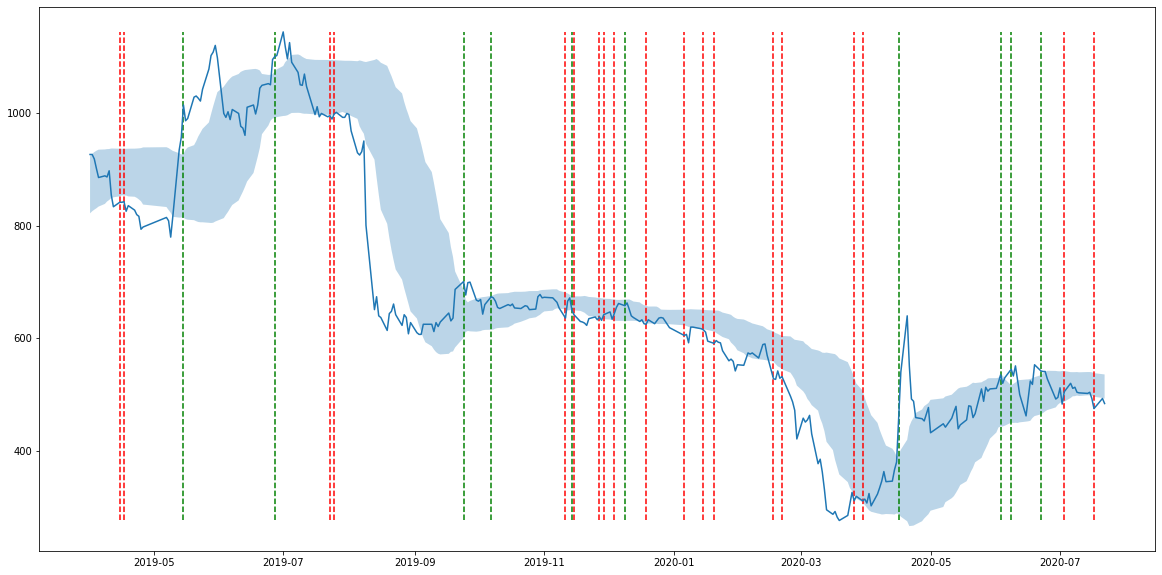

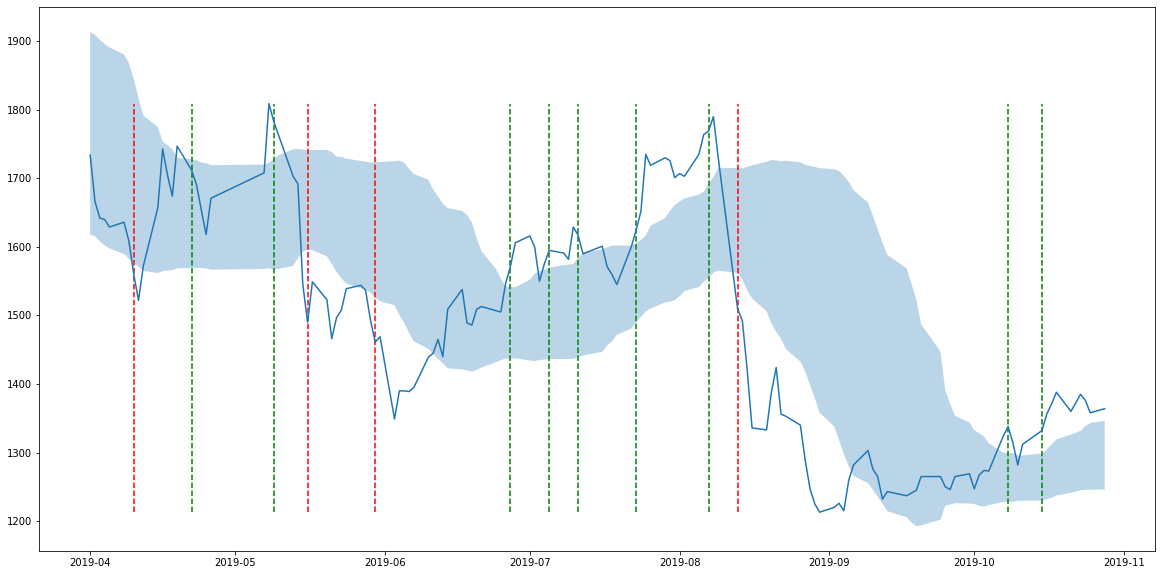

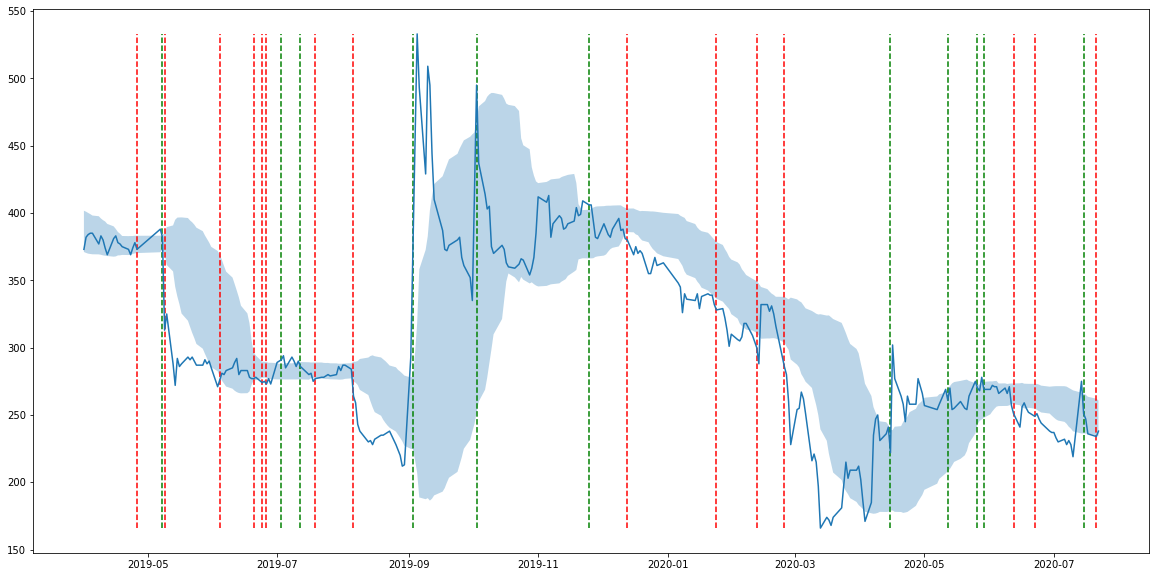

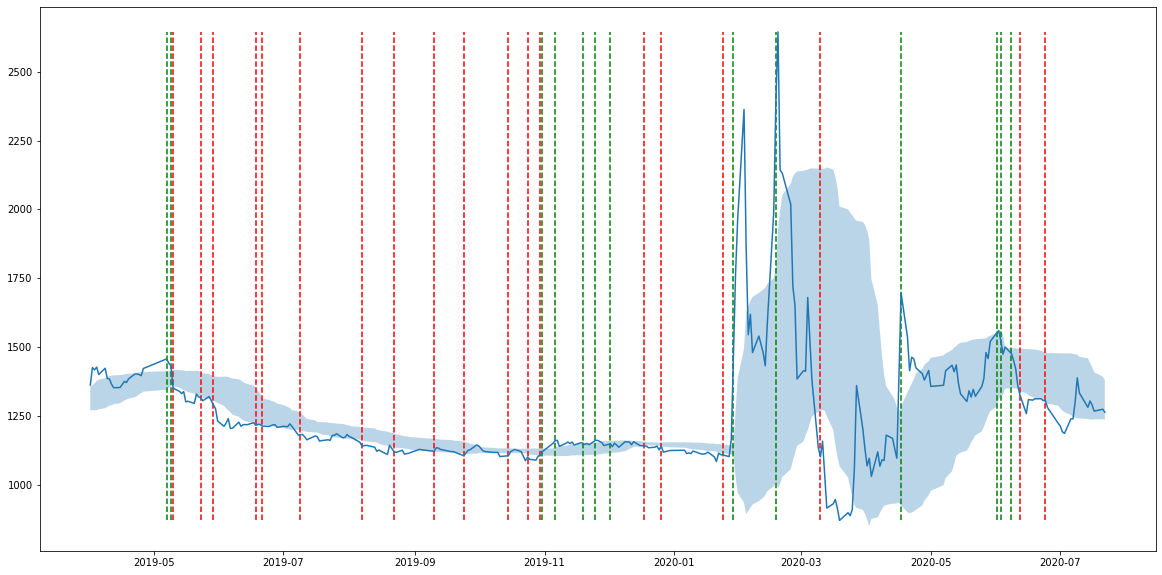

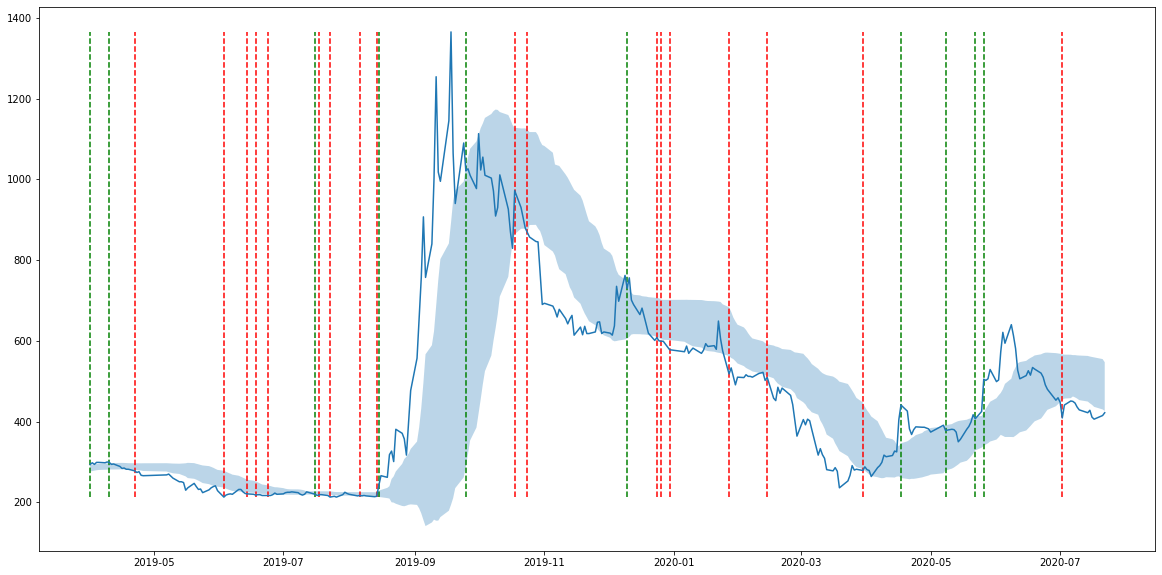

In [50]:
for code in list(signals.keys()):
    df = signals[code][start_dt:]
    plt.figure(figsize=(20, 10))
    plt.plot(df.index, df['終値'])
    plt.fill_between(df.index, df['rolling_lower_sigma'], df['rolling_upper_sigma'], alpha=0.3)
    plt.vlines(df[df['buy_signal']].index, ymin=df['終値'].min(), ymax=df['終値'].max(), color='red', linestyles='dashed')
    plt.vlines(df[df['sell_signal']].index, ymin=df['終値'].min(), ymax=df['終値'].max(), color='green', linestyles='dashed')
    plt.show()

### バックテスト

In [39]:
bollinger_trade_algo = SimulatedAlgo(
    timing_rule=EverydayTimingRule(),
    stock_selection_rule=StockSelectionRule(),
    volume_rule=BollingerBandVolumeRule(),
    init_portfolio=Portfolio(cash=100000)
)

back_test = BackTest(bollinger_trade_algo)

In [40]:
back_test.run(
    start_dt=start_dt,
    end_dt=end_dt,
)

waiting until 2019-04-02 10:00:00


INFO : 2020-08-02 08:19:22,601 : [BaseTransaction] Skipped transaction, stock=3853, volume=0 : volume is 0
INFO : 2020-08-02 08:19:22,603 : [BaseTransaction] Skipped transaction, stock=3987, volume=0 : volume is 0
INFO : 2020-08-02 08:19:22,610 : [BaseTransaction] Skipped transaction, stock=6029, volume=0 : volume is 0
INFO : 2020-08-02 08:19:22,613 : [BaseTransaction] Skipped transaction, stock=4120, volume=0 : volume is 0
INFO : 2020-08-02 08:19:22,616 : [BaseTransaction] Skipped transaction, stock=3747, volume=0 : volume is 0


waiting until 2019-04-03 10:00:00


INFO : 2020-08-02 08:19:22,911 : [BaseTransaction] Skipped transaction, stock=3853, volume=0 : volume is 0
INFO : 2020-08-02 08:19:22,913 : [BaseTransaction] Skipped transaction, stock=3987, volume=0 : volume is 0
INFO : 2020-08-02 08:19:22,915 : [BaseTransaction] Skipped transaction, stock=6029, volume=0 : volume is 0
INFO : 2020-08-02 08:19:22,917 : [BaseTransaction] Skipped transaction, stock=4120, volume=0 : volume is 0
INFO : 2020-08-02 08:19:22,919 : [BaseTransaction] Skipped transaction, stock=3747, volume=0 : volume is 0


waiting until 2019-04-04 10:00:00


INFO : 2020-08-02 08:19:23,217 : [BaseTransaction] Skipped transaction, stock=3853, volume=0 : volume is 0
INFO : 2020-08-02 08:19:23,219 : [BaseTransaction] Skipped transaction, stock=3987, volume=0 : volume is 0
INFO : 2020-08-02 08:19:23,223 : [BaseTransaction] Skipped transaction, stock=6029, volume=0 : volume is 0
INFO : 2020-08-02 08:19:23,226 : [BaseTransaction] Skipped transaction, stock=4120, volume=0 : volume is 0
INFO : 2020-08-02 08:19:23,228 : [BaseTransaction] Skipped transaction, stock=3747, volume=0 : volume is 0


waiting until 2019-04-05 10:00:00


INFO : 2020-08-02 08:19:23,514 : [BaseTransaction] Skipped transaction, stock=3853, volume=0 : volume is 0
INFO : 2020-08-02 08:19:23,519 : [BaseTransaction] Skipped transaction, stock=3987, volume=0 : volume is 0
INFO : 2020-08-02 08:19:23,520 : [BaseTransaction] Skipped transaction, stock=6029, volume=0 : volume is 0
INFO : 2020-08-02 08:19:23,526 : [BaseTransaction] Skipped transaction, stock=4120, volume=0 : volume is 0
INFO : 2020-08-02 08:19:23,527 : [BaseTransaction] Skipped transaction, stock=3747, volume=0 : volume is 0


waiting until 2019-04-08 10:00:00


INFO : 2020-08-02 08:19:24,372 : [BaseTransaction] Skipped transaction, stock=3853, volume=0 : volume is 0
INFO : 2020-08-02 08:19:24,374 : [BaseTransaction] Skipped transaction, stock=3987, volume=0 : volume is 0
INFO : 2020-08-02 08:19:24,382 : [BaseTransaction] Skipped transaction, stock=6029, volume=0 : volume is 0
INFO : 2020-08-02 08:19:24,383 : [BaseTransaction] Skipped transaction, stock=4120, volume=0 : volume is 0
INFO : 2020-08-02 08:19:24,391 : [BaseTransaction] Skipped transaction, stock=3747, volume=0 : volume is 0


waiting until 2019-04-09 10:00:00


INFO : 2020-08-02 08:19:24,677 : [BaseTransaction] Skipped transaction, stock=3853, volume=0 : volume is 0
INFO : 2020-08-02 08:19:24,679 : [BaseTransaction] Skipped transaction, stock=3987, volume=0 : volume is 0
INFO : 2020-08-02 08:19:24,684 : [BaseTransaction] Skipped transaction, stock=6029, volume=0 : volume is 0
INFO : 2020-08-02 08:19:24,686 : [BaseTransaction] Skipped transaction, stock=4120, volume=0 : volume is 0
INFO : 2020-08-02 08:19:24,688 : [BaseTransaction] Skipped transaction, stock=3747, volume=0 : volume is 0


waiting until 2019-04-10 10:00:00


INFO : 2020-08-02 08:19:24,975 : [BaseTransaction] Skipped transaction, stock=3853, volume=0 : volume is 0
INFO : 2020-08-02 08:19:24,980 : [BaseTransaction] Skipped transaction, stock=6029, volume=0 : volume is 0
INFO : 2020-08-02 08:19:24,981 : [BaseTransaction] Skipped transaction, stock=4120, volume=0 : volume is 0
INFO : 2020-08-02 08:19:24,995 : [BaseTransaction] Skipped transaction, stock=3747, volume=-2 : stock is insufficient to sell


buy/sell : 2019-04-10 10:00:00 : code=3987 : volume=4 : cash=-6260 : 
waiting until 2019-04-11 10:00:00


INFO : 2020-08-02 08:19:25,284 : [BaseTransaction] Skipped transaction, stock=3853, volume=0 : volume is 0
INFO : 2020-08-02 08:19:25,286 : [BaseTransaction] Skipped transaction, stock=3987, volume=0 : volume is 0
INFO : 2020-08-02 08:19:25,290 : [BaseTransaction] Skipped transaction, stock=6029, volume=0 : volume is 0
INFO : 2020-08-02 08:19:25,292 : [BaseTransaction] Skipped transaction, stock=4120, volume=0 : volume is 0
INFO : 2020-08-02 08:19:25,294 : [BaseTransaction] Skipped transaction, stock=3747, volume=0 : volume is 0


waiting until 2019-04-12 10:00:00


INFO : 2020-08-02 08:19:25,587 : [BaseTransaction] Skipped transaction, stock=3853, volume=0 : volume is 0
INFO : 2020-08-02 08:19:25,589 : [BaseTransaction] Skipped transaction, stock=3987, volume=0 : volume is 0
INFO : 2020-08-02 08:19:25,595 : [BaseTransaction] Skipped transaction, stock=6029, volume=0 : volume is 0
INFO : 2020-08-02 08:19:25,597 : [BaseTransaction] Skipped transaction, stock=4120, volume=0 : volume is 0
INFO : 2020-08-02 08:19:25,601 : [BaseTransaction] Skipped transaction, stock=3747, volume=0 : volume is 0


waiting until 2019-04-15 10:00:00


INFO : 2020-08-02 08:19:26,458 : [BaseTransaction] Skipped transaction, stock=3987, volume=0 : volume is 0
INFO : 2020-08-02 08:19:26,463 : [BaseTransaction] Skipped transaction, stock=6029, volume=0 : volume is 0
INFO : 2020-08-02 08:19:26,465 : [BaseTransaction] Skipped transaction, stock=4120, volume=0 : volume is 0
INFO : 2020-08-02 08:19:26,466 : [BaseTransaction] Skipped transaction, stock=3747, volume=0 : volume is 0


buy/sell : 2019-04-15 10:00:00 : code=3853 : volume=5 : cash=-4215 : 
waiting until 2019-04-16 10:00:00


INFO : 2020-08-02 08:19:26,757 : [BaseTransaction] Skipped transaction, stock=3853, volume=0 : volume is 0
INFO : 2020-08-02 08:19:26,759 : [BaseTransaction] Skipped transaction, stock=3987, volume=0 : volume is 0
INFO : 2020-08-02 08:19:26,760 : [BaseTransaction] Skipped transaction, stock=6029, volume=0 : volume is 0
INFO : 2020-08-02 08:19:26,762 : [BaseTransaction] Skipped transaction, stock=4120, volume=0 : volume is 0
INFO : 2020-08-02 08:19:26,764 : [BaseTransaction] Skipped transaction, stock=3747, volume=0 : volume is 0


waiting until 2019-04-17 10:00:00


INFO : 2020-08-02 08:19:27,054 : [BaseTransaction] Skipped transaction, stock=3987, volume=0 : volume is 0
INFO : 2020-08-02 08:19:27,056 : [BaseTransaction] Skipped transaction, stock=6029, volume=0 : volume is 0
INFO : 2020-08-02 08:19:27,064 : [BaseTransaction] Skipped transaction, stock=4120, volume=0 : volume is 0
INFO : 2020-08-02 08:19:27,065 : [BaseTransaction] Skipped transaction, stock=3747, volume=0 : volume is 0


buy/sell : 2019-04-17 10:00:00 : code=3853 : volume=2 : cash=-1684 : 
waiting until 2019-04-18 10:00:00


INFO : 2020-08-02 08:19:27,358 : [BaseTransaction] Skipped transaction, stock=3853, volume=0 : volume is 0
INFO : 2020-08-02 08:19:27,360 : [BaseTransaction] Skipped transaction, stock=3987, volume=0 : volume is 0
INFO : 2020-08-02 08:19:27,363 : [BaseTransaction] Skipped transaction, stock=6029, volume=0 : volume is 0
INFO : 2020-08-02 08:19:27,366 : [BaseTransaction] Skipped transaction, stock=4120, volume=0 : volume is 0
INFO : 2020-08-02 08:19:27,368 : [BaseTransaction] Skipped transaction, stock=3747, volume=0 : volume is 0


waiting until 2019-04-19 10:00:00


INFO : 2020-08-02 08:19:27,652 : [BaseTransaction] Skipped transaction, stock=3853, volume=0 : volume is 0
INFO : 2020-08-02 08:19:27,654 : [BaseTransaction] Skipped transaction, stock=3987, volume=0 : volume is 0
INFO : 2020-08-02 08:19:27,656 : [BaseTransaction] Skipped transaction, stock=6029, volume=0 : volume is 0
INFO : 2020-08-02 08:19:27,658 : [BaseTransaction] Skipped transaction, stock=4120, volume=0 : volume is 0
INFO : 2020-08-02 08:19:27,660 : [BaseTransaction] Skipped transaction, stock=3747, volume=0 : volume is 0


waiting until 2019-04-22 10:00:00


INFO : 2020-08-02 08:19:28,493 : [BaseTransaction] Skipped transaction, stock=3853, volume=0 : volume is 0
INFO : 2020-08-02 08:19:28,496 : [BaseTransaction] Skipped transaction, stock=6029, volume=0 : volume is 0
INFO : 2020-08-02 08:19:28,502 : [BaseTransaction] Skipped transaction, stock=4120, volume=0 : volume is 0


buy/sell : 2019-04-22 10:00:00 : code=3987 : volume=-4 : cash=6964 : 
buy/sell : 2019-04-22 10:00:00 : code=3747 : volume=2 : cash=-556 : 
waiting until 2019-04-23 10:00:00


INFO : 2020-08-02 08:19:28,787 : [BaseTransaction] Skipped transaction, stock=3853, volume=0 : volume is 0
INFO : 2020-08-02 08:19:28,789 : [BaseTransaction] Skipped transaction, stock=3987, volume=0 : volume is 0
INFO : 2020-08-02 08:19:28,792 : [BaseTransaction] Skipped transaction, stock=6029, volume=0 : volume is 0
INFO : 2020-08-02 08:19:28,795 : [BaseTransaction] Skipped transaction, stock=4120, volume=0 : volume is 0
INFO : 2020-08-02 08:19:28,798 : [BaseTransaction] Skipped transaction, stock=3747, volume=0 : volume is 0


waiting until 2019-04-24 10:00:00


INFO : 2020-08-02 08:19:29,085 : [BaseTransaction] Skipped transaction, stock=3853, volume=0 : volume is 0
INFO : 2020-08-02 08:19:29,090 : [BaseTransaction] Skipped transaction, stock=3987, volume=0 : volume is 0
INFO : 2020-08-02 08:19:29,092 : [BaseTransaction] Skipped transaction, stock=6029, volume=0 : volume is 0
INFO : 2020-08-02 08:19:29,097 : [BaseTransaction] Skipped transaction, stock=4120, volume=0 : volume is 0
INFO : 2020-08-02 08:19:29,099 : [BaseTransaction] Skipped transaction, stock=3747, volume=0 : volume is 0


waiting until 2019-04-25 10:00:00


INFO : 2020-08-02 08:19:29,379 : [BaseTransaction] Skipped transaction, stock=3853, volume=0 : volume is 0
INFO : 2020-08-02 08:19:29,380 : [BaseTransaction] Skipped transaction, stock=3987, volume=0 : volume is 0
INFO : 2020-08-02 08:19:29,382 : [BaseTransaction] Skipped transaction, stock=6029, volume=0 : volume is 0
INFO : 2020-08-02 08:19:29,384 : [BaseTransaction] Skipped transaction, stock=4120, volume=0 : volume is 0
INFO : 2020-08-02 08:19:29,386 : [BaseTransaction] Skipped transaction, stock=3747, volume=0 : volume is 0


waiting until 2019-04-26 10:00:00


INFO : 2020-08-02 08:19:29,673 : [BaseTransaction] Skipped transaction, stock=3853, volume=0 : volume is 0
INFO : 2020-08-02 08:19:29,675 : [BaseTransaction] Skipped transaction, stock=3987, volume=0 : volume is 0
INFO : 2020-08-02 08:19:29,685 : [BaseTransaction] Skipped transaction, stock=4120, volume=0 : volume is 0
INFO : 2020-08-02 08:19:29,686 : [BaseTransaction] Skipped transaction, stock=3747, volume=0 : volume is 0


buy/sell : 2019-04-26 10:00:00 : code=6029 : volume=1 : cash=-371 : 
waiting until 2019-04-30 10:00:00


INFO : 2020-08-02 08:19:30,806 : [BaseTransaction] Skipped transaction, stock=3853, volume=0 : volume is 0
INFO : 2020-08-02 08:19:30,808 : [BaseTransaction] Skipped transaction, stock=3987, volume=0 : volume is 0
INFO : 2020-08-02 08:19:30,816 : [BaseTransaction] Skipped transaction, stock=6029, volume=0 : volume is 0
INFO : 2020-08-02 08:19:30,817 : [BaseTransaction] Skipped transaction, stock=4120, volume=0 : volume is 0
INFO : 2020-08-02 08:19:30,823 : [BaseTransaction] Skipped transaction, stock=3747, volume=0 : volume is 0


Skipping transaction : datetime.datetime(2019, 4, 30, 0, 0)
Skipping transaction : datetime.datetime(2019, 4, 30, 0, 0)
Skipping transaction : datetime.datetime(2019, 4, 30, 0, 0)
Skipping transaction : datetime.datetime(2019, 4, 30, 0, 0)
Skipping transaction : datetime.datetime(2019, 4, 30, 0, 0)
waiting until 2019-05-01 10:00:00


INFO : 2020-08-02 08:19:31,106 : [BaseTransaction] Skipped transaction, stock=3853, volume=0 : volume is 0
INFO : 2020-08-02 08:19:31,107 : [BaseTransaction] Skipped transaction, stock=3987, volume=0 : volume is 0
INFO : 2020-08-02 08:19:31,110 : [BaseTransaction] Skipped transaction, stock=6029, volume=0 : volume is 0
INFO : 2020-08-02 08:19:31,112 : [BaseTransaction] Skipped transaction, stock=4120, volume=0 : volume is 0
INFO : 2020-08-02 08:19:31,114 : [BaseTransaction] Skipped transaction, stock=3747, volume=0 : volume is 0


Skipping transaction : datetime.datetime(2019, 5, 1, 0, 0)
Skipping transaction : datetime.datetime(2019, 5, 1, 0, 0)
Skipping transaction : datetime.datetime(2019, 5, 1, 0, 0)
Skipping transaction : datetime.datetime(2019, 5, 1, 0, 0)
Skipping transaction : datetime.datetime(2019, 5, 1, 0, 0)
waiting until 2019-05-02 10:00:00


INFO : 2020-08-02 08:19:31,398 : [BaseTransaction] Skipped transaction, stock=3853, volume=0 : volume is 0
INFO : 2020-08-02 08:19:31,399 : [BaseTransaction] Skipped transaction, stock=3987, volume=0 : volume is 0
INFO : 2020-08-02 08:19:31,402 : [BaseTransaction] Skipped transaction, stock=6029, volume=0 : volume is 0
INFO : 2020-08-02 08:19:31,404 : [BaseTransaction] Skipped transaction, stock=4120, volume=0 : volume is 0
INFO : 2020-08-02 08:19:31,406 : [BaseTransaction] Skipped transaction, stock=3747, volume=0 : volume is 0


Skipping transaction : datetime.datetime(2019, 5, 2, 0, 0)
Skipping transaction : datetime.datetime(2019, 5, 2, 0, 0)
Skipping transaction : datetime.datetime(2019, 5, 2, 0, 0)
Skipping transaction : datetime.datetime(2019, 5, 2, 0, 0)
Skipping transaction : datetime.datetime(2019, 5, 2, 0, 0)
waiting until 2019-05-07 10:00:00


INFO : 2020-08-02 08:19:32,795 : [BaseTransaction] Skipped transaction, stock=3853, volume=0 : volume is 0
INFO : 2020-08-02 08:19:32,797 : [BaseTransaction] Skipped transaction, stock=3987, volume=0 : volume is 0
INFO : 2020-08-02 08:19:32,804 : [BaseTransaction] Skipped transaction, stock=6029, volume=0 : volume is 0
INFO : 2020-08-02 08:19:32,813 : [BaseTransaction] Skipped transaction, stock=4120, volume=-2 : stock is insufficient to sell
INFO : 2020-08-02 08:19:32,814 : [BaseTransaction] Skipped transaction, stock=3747, volume=0 : volume is 0


waiting until 2019-05-08 10:00:00


INFO : 2020-08-02 08:19:33,102 : [BaseTransaction] Skipped transaction, stock=3853, volume=0 : volume is 0
INFO : 2020-08-02 08:19:33,104 : [BaseTransaction] Skipped transaction, stock=3987, volume=0 : volume is 0
INFO : 2020-08-02 08:19:33,108 : [BaseTransaction] Skipped transaction, stock=6029, volume=-4 : stock is insufficient to sell
INFO : 2020-08-02 08:19:33,111 : [BaseTransaction] Skipped transaction, stock=4120, volume=0 : volume is 0
INFO : 2020-08-02 08:19:33,116 : [BaseTransaction] Skipped transaction, stock=3747, volume=0 : volume is 0


waiting until 2019-05-09 10:00:00


INFO : 2020-08-02 08:19:33,394 : [BaseTransaction] Skipped transaction, stock=3853, volume=0 : volume is 0
INFO : 2020-08-02 08:19:33,396 : [BaseTransaction] Skipped transaction, stock=3987, volume=-2 : stock is insufficient to sell
INFO : 2020-08-02 08:19:33,402 : [BaseTransaction] Skipped transaction, stock=4120, volume=-5 : stock is insufficient to sell
INFO : 2020-08-02 08:19:33,403 : [BaseTransaction] Skipped transaction, stock=3747, volume=0 : volume is 0


buy/sell : 2019-05-09 10:00:00 : code=6029 : volume=4 : cash=-1340 : 
waiting until 2019-05-10 10:00:00


INFO : 2020-08-02 08:19:33,690 : [BaseTransaction] Skipped transaction, stock=3853, volume=0 : volume is 0
INFO : 2020-08-02 08:19:33,691 : [BaseTransaction] Skipped transaction, stock=3987, volume=0 : volume is 0
INFO : 2020-08-02 08:19:33,693 : [BaseTransaction] Skipped transaction, stock=6029, volume=0 : volume is 0
INFO : 2020-08-02 08:19:33,699 : [BaseTransaction] Skipped transaction, stock=3747, volume=0 : volume is 0


buy/sell : 2019-05-10 10:00:00 : code=4120 : volume=1 : cash=-1336 : 
waiting until 2019-05-13 10:00:00


INFO : 2020-08-02 08:19:34,532 : [BaseTransaction] Skipped transaction, stock=3853, volume=0 : volume is 0
INFO : 2020-08-02 08:19:34,533 : [BaseTransaction] Skipped transaction, stock=3987, volume=0 : volume is 0
INFO : 2020-08-02 08:19:34,535 : [BaseTransaction] Skipped transaction, stock=6029, volume=0 : volume is 0
INFO : 2020-08-02 08:19:34,537 : [BaseTransaction] Skipped transaction, stock=4120, volume=0 : volume is 0
INFO : 2020-08-02 08:19:34,538 : [BaseTransaction] Skipped transaction, stock=3747, volume=0 : volume is 0


waiting until 2019-05-14 10:00:00


INFO : 2020-08-02 08:19:34,826 : [BaseTransaction] Skipped transaction, stock=3853, volume=0 : volume is 0
INFO : 2020-08-02 08:19:34,828 : [BaseTransaction] Skipped transaction, stock=3987, volume=0 : volume is 0
INFO : 2020-08-02 08:19:34,832 : [BaseTransaction] Skipped transaction, stock=6029, volume=0 : volume is 0
INFO : 2020-08-02 08:19:34,839 : [BaseTransaction] Skipped transaction, stock=4120, volume=0 : volume is 0
INFO : 2020-08-02 08:19:34,840 : [BaseTransaction] Skipped transaction, stock=3747, volume=0 : volume is 0


waiting until 2019-05-15 10:00:00


INFO : 2020-08-02 08:19:35,128 : [BaseTransaction] Skipped transaction, stock=3987, volume=0 : volume is 0
INFO : 2020-08-02 08:19:35,130 : [BaseTransaction] Skipped transaction, stock=6029, volume=0 : volume is 0
INFO : 2020-08-02 08:19:35,134 : [BaseTransaction] Skipped transaction, stock=4120, volume=0 : volume is 0
INFO : 2020-08-02 08:19:35,137 : [BaseTransaction] Skipped transaction, stock=3747, volume=0 : volume is 0


buy/sell : 2019-05-15 10:00:00 : code=3853 : volume=-1 : cash=991 : 
waiting until 2019-05-16 10:00:00


INFO : 2020-08-02 08:19:35,421 : [BaseTransaction] Skipped transaction, stock=3853, volume=0 : volume is 0
INFO : 2020-08-02 08:19:35,424 : [BaseTransaction] Skipped transaction, stock=6029, volume=0 : volume is 0
INFO : 2020-08-02 08:19:35,426 : [BaseTransaction] Skipped transaction, stock=4120, volume=0 : volume is 0
INFO : 2020-08-02 08:19:35,428 : [BaseTransaction] Skipped transaction, stock=3747, volume=0 : volume is 0


buy/sell : 2019-05-16 10:00:00 : code=3987 : volume=4 : cash=-6124 : 
waiting until 2019-05-17 10:00:00


INFO : 2020-08-02 08:19:35,714 : [BaseTransaction] Skipped transaction, stock=3853, volume=0 : volume is 0
INFO : 2020-08-02 08:19:35,715 : [BaseTransaction] Skipped transaction, stock=3987, volume=0 : volume is 0
INFO : 2020-08-02 08:19:35,717 : [BaseTransaction] Skipped transaction, stock=6029, volume=0 : volume is 0
INFO : 2020-08-02 08:19:35,720 : [BaseTransaction] Skipped transaction, stock=4120, volume=0 : volume is 0
INFO : 2020-08-02 08:19:35,722 : [BaseTransaction] Skipped transaction, stock=3747, volume=0 : volume is 0


waiting until 2019-05-20 10:00:00


INFO : 2020-08-02 08:19:36,556 : [BaseTransaction] Skipped transaction, stock=3853, volume=0 : volume is 0
INFO : 2020-08-02 08:19:36,562 : [BaseTransaction] Skipped transaction, stock=3987, volume=0 : volume is 0
INFO : 2020-08-02 08:19:36,566 : [BaseTransaction] Skipped transaction, stock=6029, volume=0 : volume is 0
INFO : 2020-08-02 08:19:36,568 : [BaseTransaction] Skipped transaction, stock=4120, volume=0 : volume is 0
INFO : 2020-08-02 08:19:36,570 : [BaseTransaction] Skipped transaction, stock=3747, volume=0 : volume is 0


waiting until 2019-05-21 10:00:00


INFO : 2020-08-02 08:19:36,886 : [BaseTransaction] Skipped transaction, stock=3853, volume=0 : volume is 0
INFO : 2020-08-02 08:19:36,888 : [BaseTransaction] Skipped transaction, stock=3987, volume=0 : volume is 0
INFO : 2020-08-02 08:19:36,889 : [BaseTransaction] Skipped transaction, stock=6029, volume=0 : volume is 0
INFO : 2020-08-02 08:19:36,891 : [BaseTransaction] Skipped transaction, stock=4120, volume=0 : volume is 0
INFO : 2020-08-02 08:19:36,896 : [BaseTransaction] Skipped transaction, stock=3747, volume=0 : volume is 0


waiting until 2019-05-22 10:00:00


INFO : 2020-08-02 08:19:37,182 : [BaseTransaction] Skipped transaction, stock=3853, volume=0 : volume is 0
INFO : 2020-08-02 08:19:37,187 : [BaseTransaction] Skipped transaction, stock=3987, volume=0 : volume is 0
INFO : 2020-08-02 08:19:37,191 : [BaseTransaction] Skipped transaction, stock=6029, volume=0 : volume is 0
INFO : 2020-08-02 08:19:37,192 : [BaseTransaction] Skipped transaction, stock=4120, volume=0 : volume is 0
INFO : 2020-08-02 08:19:37,194 : [BaseTransaction] Skipped transaction, stock=3747, volume=0 : volume is 0


waiting until 2019-05-23 10:00:00


INFO : 2020-08-02 08:19:37,477 : [BaseTransaction] Skipped transaction, stock=3853, volume=0 : volume is 0
INFO : 2020-08-02 08:19:37,479 : [BaseTransaction] Skipped transaction, stock=3987, volume=0 : volume is 0
INFO : 2020-08-02 08:19:37,483 : [BaseTransaction] Skipped transaction, stock=6029, volume=0 : volume is 0
INFO : 2020-08-02 08:19:37,490 : [BaseTransaction] Skipped transaction, stock=3747, volume=0 : volume is 0


buy/sell : 2019-05-23 10:00:00 : code=4120 : volume=1 : cash=-1314 : 
waiting until 2019-05-24 10:00:00


INFO : 2020-08-02 08:19:37,774 : [BaseTransaction] Skipped transaction, stock=3853, volume=0 : volume is 0
INFO : 2020-08-02 08:19:37,775 : [BaseTransaction] Skipped transaction, stock=3987, volume=0 : volume is 0
INFO : 2020-08-02 08:19:37,777 : [BaseTransaction] Skipped transaction, stock=6029, volume=0 : volume is 0
INFO : 2020-08-02 08:19:37,779 : [BaseTransaction] Skipped transaction, stock=4120, volume=0 : volume is 0
INFO : 2020-08-02 08:19:37,783 : [BaseTransaction] Skipped transaction, stock=3747, volume=0 : volume is 0


waiting until 2019-05-27 10:00:00


INFO : 2020-08-02 08:19:38,642 : [BaseTransaction] Skipped transaction, stock=3853, volume=0 : volume is 0
INFO : 2020-08-02 08:19:38,645 : [BaseTransaction] Skipped transaction, stock=3987, volume=0 : volume is 0
INFO : 2020-08-02 08:19:38,647 : [BaseTransaction] Skipped transaction, stock=6029, volume=0 : volume is 0
INFO : 2020-08-02 08:19:38,649 : [BaseTransaction] Skipped transaction, stock=4120, volume=0 : volume is 0
INFO : 2020-08-02 08:19:38,652 : [BaseTransaction] Skipped transaction, stock=3747, volume=0 : volume is 0


waiting until 2019-05-28 10:00:00


INFO : 2020-08-02 08:19:38,950 : [BaseTransaction] Skipped transaction, stock=3853, volume=0 : volume is 0
INFO : 2020-08-02 08:19:38,952 : [BaseTransaction] Skipped transaction, stock=3987, volume=0 : volume is 0
INFO : 2020-08-02 08:19:38,960 : [BaseTransaction] Skipped transaction, stock=6029, volume=0 : volume is 0
INFO : 2020-08-02 08:19:38,961 : [BaseTransaction] Skipped transaction, stock=4120, volume=0 : volume is 0
INFO : 2020-08-02 08:19:38,968 : [BaseTransaction] Skipped transaction, stock=3747, volume=0 : volume is 0


waiting until 2019-05-29 10:00:00


INFO : 2020-08-02 08:19:39,261 : [BaseTransaction] Skipped transaction, stock=3853, volume=0 : volume is 0
INFO : 2020-08-02 08:19:39,263 : [BaseTransaction] Skipped transaction, stock=3987, volume=0 : volume is 0
INFO : 2020-08-02 08:19:39,265 : [BaseTransaction] Skipped transaction, stock=6029, volume=0 : volume is 0
INFO : 2020-08-02 08:19:39,271 : [BaseTransaction] Skipped transaction, stock=3747, volume=0 : volume is 0


buy/sell : 2019-05-29 10:00:00 : code=4120 : volume=1 : cash=-1295 : 
waiting until 2019-05-30 10:00:00


INFO : 2020-08-02 08:19:39,555 : [BaseTransaction] Skipped transaction, stock=3853, volume=0 : volume is 0
INFO : 2020-08-02 08:19:39,559 : [BaseTransaction] Skipped transaction, stock=6029, volume=0 : volume is 0
INFO : 2020-08-02 08:19:39,560 : [BaseTransaction] Skipped transaction, stock=4120, volume=0 : volume is 0
INFO : 2020-08-02 08:19:39,564 : [BaseTransaction] Skipped transaction, stock=3747, volume=0 : volume is 0


buy/sell : 2019-05-30 10:00:00 : code=3987 : volume=4 : cash=-5864 : 
waiting until 2019-05-31 10:00:00


INFO : 2020-08-02 08:19:39,855 : [BaseTransaction] Skipped transaction, stock=3853, volume=0 : volume is 0
INFO : 2020-08-02 08:19:39,857 : [BaseTransaction] Skipped transaction, stock=3987, volume=0 : volume is 0
INFO : 2020-08-02 08:19:39,859 : [BaseTransaction] Skipped transaction, stock=6029, volume=0 : volume is 0
INFO : 2020-08-02 08:19:39,861 : [BaseTransaction] Skipped transaction, stock=4120, volume=0 : volume is 0
INFO : 2020-08-02 08:19:39,863 : [BaseTransaction] Skipped transaction, stock=3747, volume=0 : volume is 0


waiting until 2019-06-03 10:00:00


INFO : 2020-08-02 08:19:40,709 : [BaseTransaction] Skipped transaction, stock=3853, volume=0 : volume is 0
INFO : 2020-08-02 08:19:40,711 : [BaseTransaction] Skipped transaction, stock=3987, volume=0 : volume is 0
INFO : 2020-08-02 08:19:40,713 : [BaseTransaction] Skipped transaction, stock=6029, volume=0 : volume is 0
INFO : 2020-08-02 08:19:40,714 : [BaseTransaction] Skipped transaction, stock=4120, volume=0 : volume is 0


buy/sell : 2019-06-03 10:00:00 : code=3747 : volume=5 : cash=-1095 : 
waiting until 2019-06-04 10:00:00


INFO : 2020-08-02 08:19:41,005 : [BaseTransaction] Skipped transaction, stock=3853, volume=0 : volume is 0
INFO : 2020-08-02 08:19:41,007 : [BaseTransaction] Skipped transaction, stock=3987, volume=0 : volume is 0
INFO : 2020-08-02 08:19:41,012 : [BaseTransaction] Skipped transaction, stock=4120, volume=0 : volume is 0
INFO : 2020-08-02 08:19:41,015 : [BaseTransaction] Skipped transaction, stock=3747, volume=0 : volume is 0


buy/sell : 2019-06-04 10:00:00 : code=6029 : volume=3 : cash=-816 : 
waiting until 2019-06-05 10:00:00


INFO : 2020-08-02 08:19:41,300 : [BaseTransaction] Skipped transaction, stock=3853, volume=0 : volume is 0
INFO : 2020-08-02 08:19:41,301 : [BaseTransaction] Skipped transaction, stock=3987, volume=0 : volume is 0
INFO : 2020-08-02 08:19:41,304 : [BaseTransaction] Skipped transaction, stock=6029, volume=0 : volume is 0
INFO : 2020-08-02 08:19:41,311 : [BaseTransaction] Skipped transaction, stock=4120, volume=0 : volume is 0
INFO : 2020-08-02 08:19:41,313 : [BaseTransaction] Skipped transaction, stock=3747, volume=0 : volume is 0


waiting until 2019-06-06 10:00:00


INFO : 2020-08-02 08:19:41,601 : [BaseTransaction] Skipped transaction, stock=3853, volume=0 : volume is 0
INFO : 2020-08-02 08:19:41,603 : [BaseTransaction] Skipped transaction, stock=3987, volume=0 : volume is 0
INFO : 2020-08-02 08:19:41,610 : [BaseTransaction] Skipped transaction, stock=6029, volume=0 : volume is 0
INFO : 2020-08-02 08:19:41,612 : [BaseTransaction] Skipped transaction, stock=4120, volume=0 : volume is 0
INFO : 2020-08-02 08:19:41,614 : [BaseTransaction] Skipped transaction, stock=3747, volume=0 : volume is 0


waiting until 2019-06-07 10:00:00


INFO : 2020-08-02 08:19:41,914 : [BaseTransaction] Skipped transaction, stock=3853, volume=0 : volume is 0
INFO : 2020-08-02 08:19:41,916 : [BaseTransaction] Skipped transaction, stock=3987, volume=0 : volume is 0
INFO : 2020-08-02 08:19:41,918 : [BaseTransaction] Skipped transaction, stock=6029, volume=0 : volume is 0
INFO : 2020-08-02 08:19:41,920 : [BaseTransaction] Skipped transaction, stock=4120, volume=0 : volume is 0
INFO : 2020-08-02 08:19:41,922 : [BaseTransaction] Skipped transaction, stock=3747, volume=0 : volume is 0


waiting until 2019-06-10 10:00:00


INFO : 2020-08-02 08:19:42,772 : [BaseTransaction] Skipped transaction, stock=3853, volume=0 : volume is 0
INFO : 2020-08-02 08:19:42,774 : [BaseTransaction] Skipped transaction, stock=3987, volume=0 : volume is 0
INFO : 2020-08-02 08:19:42,776 : [BaseTransaction] Skipped transaction, stock=6029, volume=0 : volume is 0
INFO : 2020-08-02 08:19:42,777 : [BaseTransaction] Skipped transaction, stock=4120, volume=0 : volume is 0
INFO : 2020-08-02 08:19:42,779 : [BaseTransaction] Skipped transaction, stock=3747, volume=0 : volume is 0


waiting until 2019-06-11 10:00:00


INFO : 2020-08-02 08:19:43,072 : [BaseTransaction] Skipped transaction, stock=3853, volume=0 : volume is 0
INFO : 2020-08-02 08:19:43,074 : [BaseTransaction] Skipped transaction, stock=3987, volume=0 : volume is 0
INFO : 2020-08-02 08:19:43,075 : [BaseTransaction] Skipped transaction, stock=6029, volume=0 : volume is 0
INFO : 2020-08-02 08:19:43,079 : [BaseTransaction] Skipped transaction, stock=4120, volume=0 : volume is 0
INFO : 2020-08-02 08:19:43,081 : [BaseTransaction] Skipped transaction, stock=3747, volume=0 : volume is 0


waiting until 2019-06-12 10:00:00


INFO : 2020-08-02 08:19:43,364 : [BaseTransaction] Skipped transaction, stock=3853, volume=0 : volume is 0
INFO : 2020-08-02 08:19:43,365 : [BaseTransaction] Skipped transaction, stock=3987, volume=0 : volume is 0
INFO : 2020-08-02 08:19:43,372 : [BaseTransaction] Skipped transaction, stock=6029, volume=0 : volume is 0
INFO : 2020-08-02 08:19:43,373 : [BaseTransaction] Skipped transaction, stock=4120, volume=0 : volume is 0
INFO : 2020-08-02 08:19:43,379 : [BaseTransaction] Skipped transaction, stock=3747, volume=0 : volume is 0


waiting until 2019-06-13 10:00:00


INFO : 2020-08-02 08:19:43,660 : [BaseTransaction] Skipped transaction, stock=3853, volume=0 : volume is 0
INFO : 2020-08-02 08:19:43,662 : [BaseTransaction] Skipped transaction, stock=3987, volume=0 : volume is 0
INFO : 2020-08-02 08:19:43,664 : [BaseTransaction] Skipped transaction, stock=6029, volume=0 : volume is 0
INFO : 2020-08-02 08:19:43,666 : [BaseTransaction] Skipped transaction, stock=4120, volume=0 : volume is 0
INFO : 2020-08-02 08:19:43,668 : [BaseTransaction] Skipped transaction, stock=3747, volume=0 : volume is 0


Skipping transaction : datetime.datetime(2019, 6, 13, 0, 0)
waiting until 2019-06-14 10:00:00


INFO : 2020-08-02 08:19:43,956 : [BaseTransaction] Skipped transaction, stock=3853, volume=0 : volume is 0
INFO : 2020-08-02 08:19:43,958 : [BaseTransaction] Skipped transaction, stock=3987, volume=0 : volume is 0
INFO : 2020-08-02 08:19:43,960 : [BaseTransaction] Skipped transaction, stock=6029, volume=0 : volume is 0
INFO : 2020-08-02 08:19:43,962 : [BaseTransaction] Skipped transaction, stock=4120, volume=0 : volume is 0


buy/sell : 2019-06-14 10:00:00 : code=3747 : volume=3 : cash=-666 : 
waiting until 2019-06-17 10:00:00


INFO : 2020-08-02 08:19:44,802 : [BaseTransaction] Skipped transaction, stock=3853, volume=0 : volume is 0
INFO : 2020-08-02 08:19:44,804 : [BaseTransaction] Skipped transaction, stock=3987, volume=0 : volume is 0
INFO : 2020-08-02 08:19:44,811 : [BaseTransaction] Skipped transaction, stock=6029, volume=0 : volume is 0
INFO : 2020-08-02 08:19:44,812 : [BaseTransaction] Skipped transaction, stock=4120, volume=0 : volume is 0
INFO : 2020-08-02 08:19:44,819 : [BaseTransaction] Skipped transaction, stock=3747, volume=0 : volume is 0


waiting until 2019-06-18 10:00:00


INFO : 2020-08-02 08:19:45,104 : [BaseTransaction] Skipped transaction, stock=3853, volume=0 : volume is 0
INFO : 2020-08-02 08:19:45,106 : [BaseTransaction] Skipped transaction, stock=3987, volume=0 : volume is 0
INFO : 2020-08-02 08:19:45,111 : [BaseTransaction] Skipped transaction, stock=6029, volume=0 : volume is 0


buy/sell : 2019-06-18 10:00:00 : code=4120 : volume=2 : cash=-2432 : 
buy/sell : 2019-06-18 10:00:00 : code=3747 : volume=5 : cash=-1095 : 
waiting until 2019-06-19 10:00:00


INFO : 2020-08-02 08:19:45,395 : [BaseTransaction] Skipped transaction, stock=3853, volume=0 : volume is 0
INFO : 2020-08-02 08:19:45,396 : [BaseTransaction] Skipped transaction, stock=3987, volume=0 : volume is 0
INFO : 2020-08-02 08:19:45,397 : [BaseTransaction] Skipped transaction, stock=6029, volume=0 : volume is 0
INFO : 2020-08-02 08:19:45,407 : [BaseTransaction] Skipped transaction, stock=4120, volume=0 : volume is 0
INFO : 2020-08-02 08:19:45,409 : [BaseTransaction] Skipped transaction, stock=3747, volume=0 : volume is 0


waiting until 2019-06-20 10:00:00


INFO : 2020-08-02 08:19:45,709 : [BaseTransaction] Skipped transaction, stock=3853, volume=0 : volume is 0
INFO : 2020-08-02 08:19:45,710 : [BaseTransaction] Skipped transaction, stock=3987, volume=0 : volume is 0
INFO : 2020-08-02 08:19:45,718 : [BaseTransaction] Skipped transaction, stock=4120, volume=0 : volume is 0
INFO : 2020-08-02 08:19:45,719 : [BaseTransaction] Skipped transaction, stock=3747, volume=0 : volume is 0


buy/sell : 2019-06-20 10:00:00 : code=6029 : volume=1 : cash=-276 : 
waiting until 2019-06-21 10:00:00


INFO : 2020-08-02 08:19:46,002 : [BaseTransaction] Skipped transaction, stock=3853, volume=0 : volume is 0
INFO : 2020-08-02 08:19:46,004 : [BaseTransaction] Skipped transaction, stock=3987, volume=0 : volume is 0
INFO : 2020-08-02 08:19:46,012 : [BaseTransaction] Skipped transaction, stock=6029, volume=0 : volume is 0
INFO : 2020-08-02 08:19:46,016 : [BaseTransaction] Skipped transaction, stock=3747, volume=0 : volume is 0


buy/sell : 2019-06-21 10:00:00 : code=4120 : volume=5 : cash=-6070 : 
waiting until 2019-06-24 10:00:00


INFO : 2020-08-02 08:19:46,840 : [BaseTransaction] Skipped transaction, stock=3853, volume=0 : volume is 0
INFO : 2020-08-02 08:19:46,841 : [BaseTransaction] Skipped transaction, stock=3987, volume=0 : volume is 0
INFO : 2020-08-02 08:19:46,848 : [BaseTransaction] Skipped transaction, stock=4120, volume=0 : volume is 0


buy/sell : 2019-06-24 10:00:00 : code=6029 : volume=1 : cash=-275 : 
buy/sell : 2019-06-24 10:00:00 : code=3747 : volume=4 : cash=-868 : 
waiting until 2019-06-25 10:00:00


INFO : 2020-08-02 08:19:47,155 : [BaseTransaction] Skipped transaction, stock=3853, volume=0 : volume is 0
INFO : 2020-08-02 08:19:47,157 : [BaseTransaction] Skipped transaction, stock=3987, volume=0 : volume is 0
INFO : 2020-08-02 08:19:47,163 : [BaseTransaction] Skipped transaction, stock=6029, volume=0 : volume is 0
INFO : 2020-08-02 08:19:47,165 : [BaseTransaction] Skipped transaction, stock=4120, volume=0 : volume is 0
INFO : 2020-08-02 08:19:47,170 : [BaseTransaction] Skipped transaction, stock=3747, volume=0 : volume is 0


Skipping transaction : datetime.datetime(2019, 6, 25, 0, 0)
waiting until 2019-06-26 10:00:00


INFO : 2020-08-02 08:19:47,450 : [BaseTransaction] Skipped transaction, stock=3853, volume=0 : volume is 0
INFO : 2020-08-02 08:19:47,451 : [BaseTransaction] Skipped transaction, stock=3987, volume=0 : volume is 0
INFO : 2020-08-02 08:19:47,456 : [BaseTransaction] Skipped transaction, stock=4120, volume=0 : volume is 0
INFO : 2020-08-02 08:19:47,458 : [BaseTransaction] Skipped transaction, stock=3747, volume=0 : volume is 0


buy/sell : 2019-06-26 10:00:00 : code=6029 : volume=5 : cash=-1370 : 
waiting until 2019-06-27 10:00:00


INFO : 2020-08-02 08:19:47,746 : [BaseTransaction] Skipped transaction, stock=6029, volume=0 : volume is 0
INFO : 2020-08-02 08:19:47,748 : [BaseTransaction] Skipped transaction, stock=4120, volume=0 : volume is 0
INFO : 2020-08-02 08:19:47,754 : [BaseTransaction] Skipped transaction, stock=3747, volume=0 : volume is 0


buy/sell : 2019-06-27 10:00:00 : code=3853 : volume=-4 : cash=4400 : 
buy/sell : 2019-06-27 10:00:00 : code=3987 : volume=-5 : cash=7830 : 
waiting until 2019-06-28 10:00:00


INFO : 2020-08-02 08:19:48,043 : [BaseTransaction] Skipped transaction, stock=3853, volume=0 : volume is 0
INFO : 2020-08-02 08:19:48,046 : [BaseTransaction] Skipped transaction, stock=3987, volume=0 : volume is 0
INFO : 2020-08-02 08:19:48,047 : [BaseTransaction] Skipped transaction, stock=6029, volume=0 : volume is 0
INFO : 2020-08-02 08:19:48,053 : [BaseTransaction] Skipped transaction, stock=4120, volume=0 : volume is 0
INFO : 2020-08-02 08:19:48,055 : [BaseTransaction] Skipped transaction, stock=3747, volume=0 : volume is 0


waiting until 2019-07-01 10:00:00


In [41]:
result = back_test.result()

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

In [43]:
df_transaction_history = result.transaction_history

In [44]:
df_transaction_history

,datetime,stock,volume
0,2019-04-10 10:00:00,3987,4
1,2019-04-15 10:00:00,3853,5
2,2019-04-17 10:00:00,3853,2
3,2019-04-22 10:00:00,3987,-4
4,2019-04-22 10:00:00,3747,2
5,2019-04-26 10:00:00,6029,1
6,2019-05-09 10:00:00,6029,4
7,2019-05-10 10:00:00,4120,1
8,2019-05-15 10:00:00,3853,-1
9,2019-05-16 10:00:00,3987,4


In [46]:
portfolio_history = result.portfolio_history
df_portfolio_history = pd.DataFrame({
    'datetime': portfolio_history['datetime'],
    'total_asset': portfolio_history['total_asset']
})
df_portfolio_history['datetime'] = pd.to_datetime(df_portfolio_history['datetime'])

In [47]:
df_portfolio_history

,datetime,total_asset
0,2019-04-10 10:00:00,100000
1,2019-04-15 10:00:00,100252
2,2019-04-17 10:00:00,100635
3,2019-04-22 10:00:00,100622
4,2019-04-22 10:00:00,100622
5,2019-04-26 10:00:00,100313
6,2019-05-09 10:00:00,100303
7,2019-05-10 10:00:00,100231
8,2019-05-15 10:00:00,101416
9,2019-05-16 10:00:00,101461


Text(0, 0.5, 'total asset')

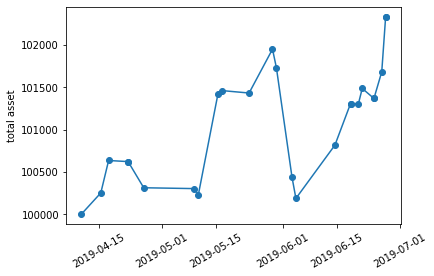

In [48]:
plt.plot(df_portfolio_history['datetime'], df_portfolio_history['total_asset'], marker='o')
plt.xticks(rotation=30)
plt.ylabel('total asset')